In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os
import numpy as np
import xarray as xr
import skimage
import matplotlib.pyplot as plt
nax = np.newaxis

sys.path.append('..')
%aimport mre_pinn

Using backend: pytorch



# BIOQIC Phantom ground truth

In [3]:
%autoreload

data, test_data = mre_pinn.data.load_bioqic_dataset('../data/BIOQIC', 'phantom', downsample=False)
data

Loading ../data/BIOQIC/phantom_unwrapped_dejittered.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    info: <class 'numpy.ndarray'> (1, 1) [('dx_m', 'O'), ('dy_m', 'O'), ('dz_m', 'O'), ('frequencies_Hz', 'O'), ('index_description', 'O'), ('size', 'O')]
    magnitude: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) uint16
    phase_unwrap_noipd: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) float64
Loading ../data/BIOQIC/phantom_elastogram.npy
Loading ../data/BIOQIC/phantom_regions.npy
Multi frequency 3D
<xarray.Dataset>
Dimensions:         (frequency: 8, component: 3, t: 8, z: 25, x: 128, y: 80)
Coordinates:
  * frequency       (frequency) float64 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0
  * component       (component) <U1 'z' 'y' 'x'
  * t               (t) int64 0 1 2 3 4 5 6 7
  * z               (z) float64 0.0 0.0015 0.003 0.0045 ... 0.033 0.0345 0.036
  * x               (x) float64 0.0 0.0015 0.003 0.0045 ... 0.1875 0.189 0.19

[Errno 2] No such file or directory: '../data/BIOQIC/phantom_elastogram.npy'
[Errno 2] No such file or directory: '../data/BIOQIC/phantom_regions.npy'


<xarray.Dataset>
Dimensions:         (frequency: 8, component: 3, t: 8, z: 25, x: 128, y: 80)
Coordinates:
  * frequency       (frequency) float64 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0
  * component       (component) <U1 'z' 'y' 'x'
  * t               (t) int64 0 1 2 3 4 5 6 7
  * z               (z) float64 0.0 0.0015 0.003 0.0045 ... 0.033 0.0345 0.036
  * x               (x) float64 0.0 0.0015 0.003 0.0045 ... 0.1875 0.189 0.1905
  * y               (y) float64 0.0 0.0015 0.003 0.0045 ... 0.1155 0.117 0.1185
Data variables:
    a               (frequency, t, x, y, z, component) uint16 0 0 0 ... 33 78 13
    u               (frequency, t, x, y, z, component) float64 -0.6366 ... -0...
    mu              (x, y, z) float64 -0.0 0.0 0.0 -0.0 ... 0.0 0.0 0.0 -0.0
    spatial_region  (x, y, z) float64 -0.0 0.0 0.0 -0.0 ... 0.0 0.0 0.0 -0.0
    Lu              (frequency, t, x, y, z, component) float64 -3.368e+06 ......
    Mu              (frequency, t, x, y, z) float64 9.081 -13.87 ... -516.2

<IPython.core.display.Javascript object>


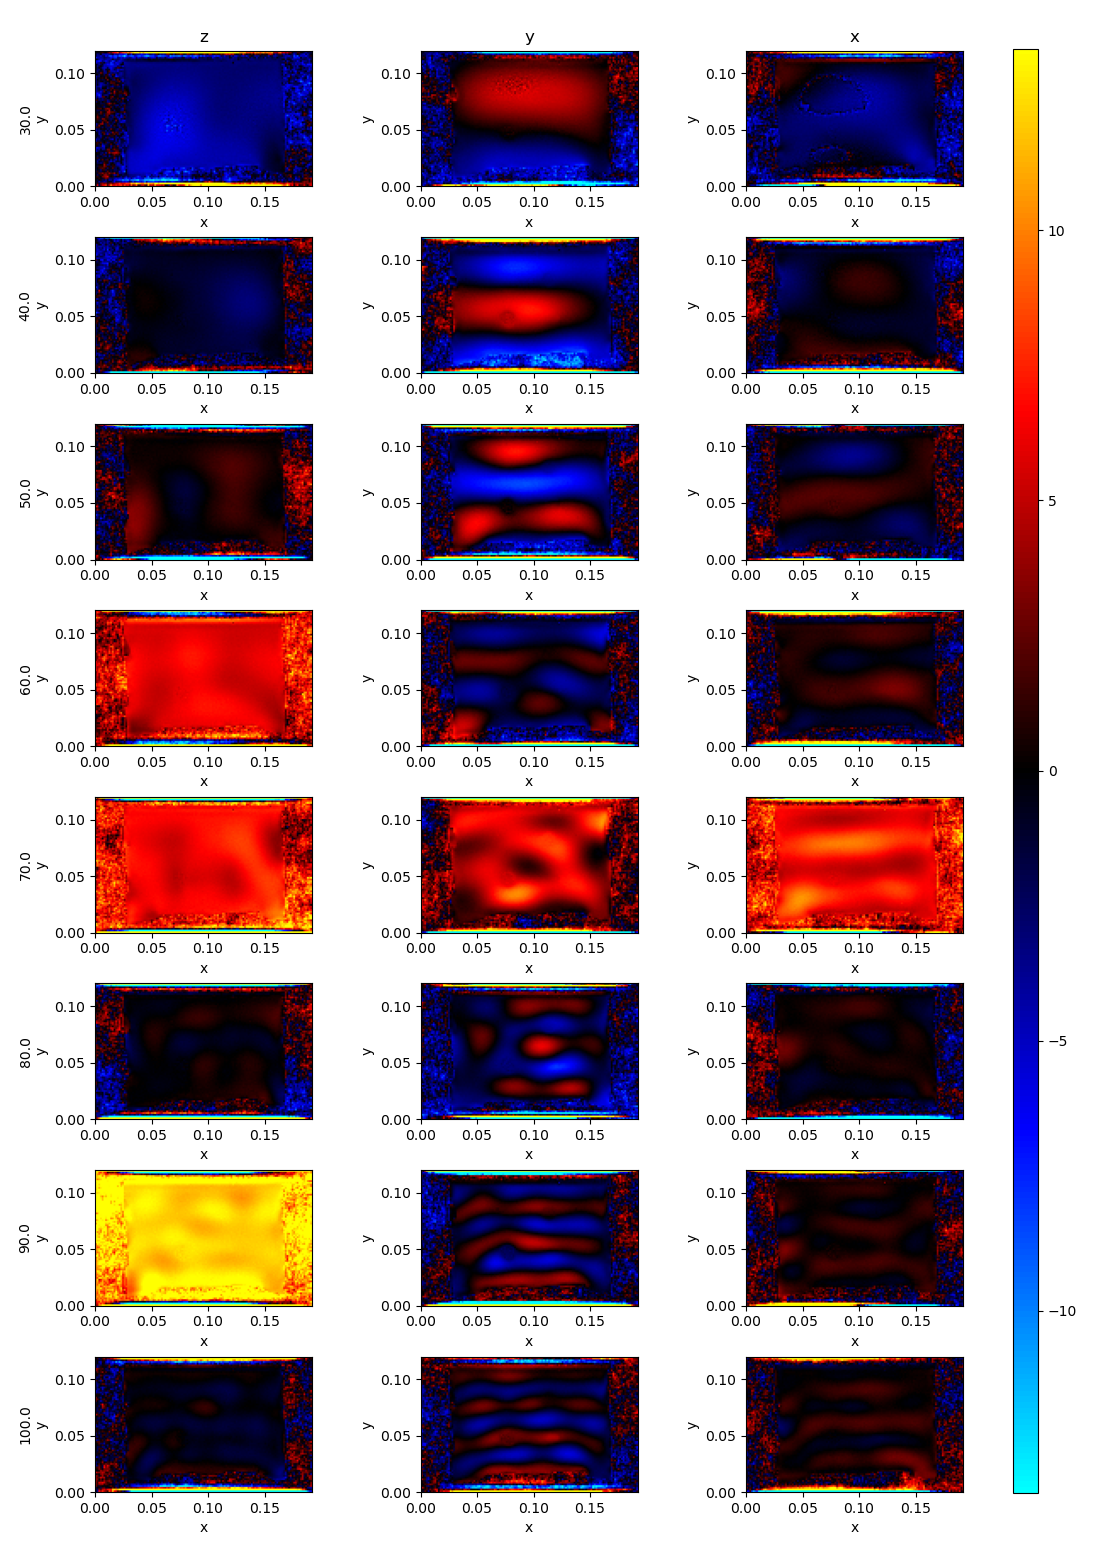

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [4]:
%autoreload

anat_kws = mre_pinn.visual.get_color_kws(data.a)
wave_kws = mre_pinn.visual.get_color_kws(data.u)
laplace_kws = mre_pinn.visual.get_color_kws(data.Lu, pct=50)
elast_kws = mre_pinn.visual.get_color_kws(data.Mu, pct=50)
mask_kws = mre_pinn.visual.get_color_kws(data.spatial_region)

mre_pinn.visual.XArrayViewer(data.u, col='component', row='frequency', **wave_kws)

In [12]:
data.field.spatial_resolution

array([0.0015, 0.0015, 0.0015])

<IPython.core.display.Javascript object>


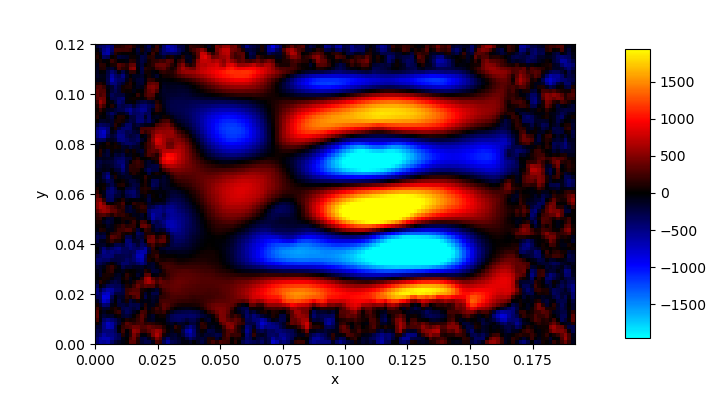

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [73]:
%autoreload
proc_data = mre_pinn.data.preprocess_bioqic_phantom_data(data, sigma=0.65, threshold=100, order=1)

wave_kws = mre_pinn.visual.get_color_kws(proc_data.u)
mre_pinn.visual.XArrayViewer(proc_data.u, ax_height=3, **wave_kws)

<IPython.core.display.Javascript object>


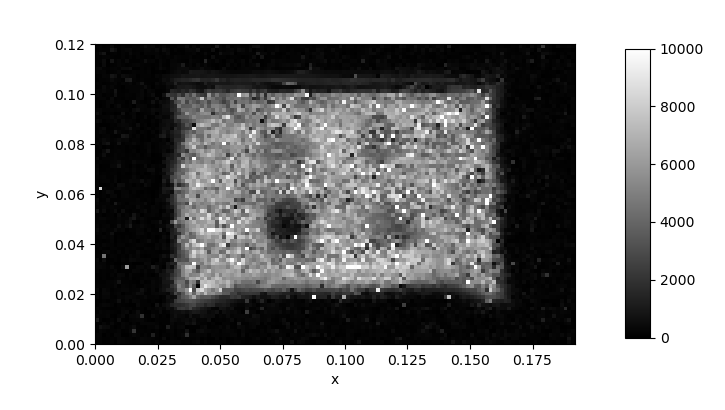

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


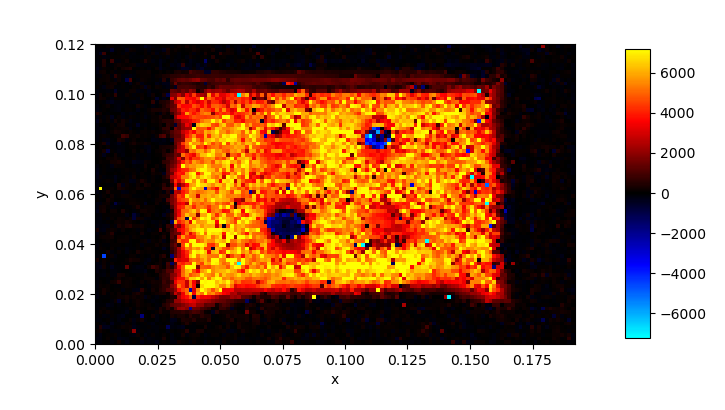

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [78]:
u = proc_data.u
Lu = mre_pinn.discrete.laplacian(u)
Mu = mre_pinn.discrete.helmholtz_inversion(u, Lu, polar=False)
Mu = Mu.mean('frequency')

mre_pinn.visual.XArrayViewer(Mu, ax_height=3, cmap='gray', vmin=0, vmax=10e3, polar=True)
mre_pinn.visual.XArrayViewer(Mu, ax_height=3, **mre_pinn.visual.get_color_kws(Mu))

<IPython.core.display.Javascript object>


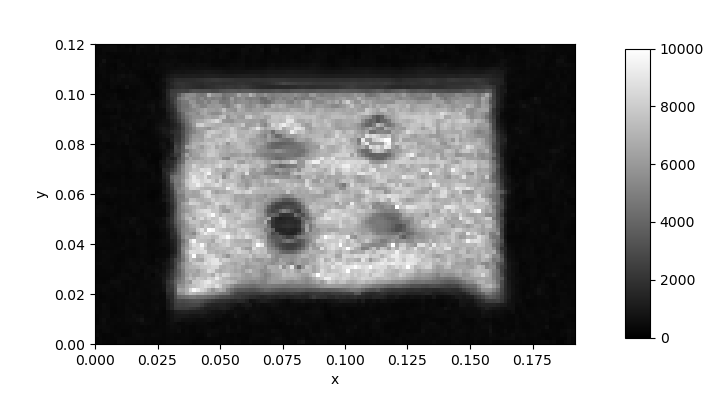

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


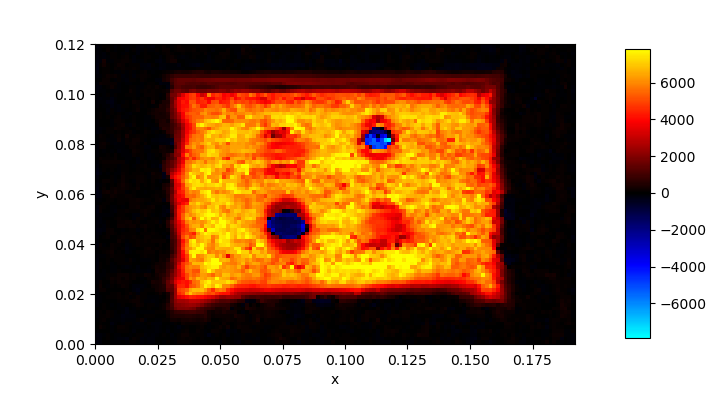

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [79]:
%autoreload

u = proc_data.u
Lu = mre_pinn.discrete.laplacian(u)
Mu = mre_pinn.discrete.helmholtz_inversion(u, Lu, polar=True)
Mu = Mu.mean('frequency')

mre_pinn.visual.XArrayViewer(Mu, ax_height=3, cmap='gray', vmin=0, vmax=10e3, polar=True)
mre_pinn.visual.XArrayViewer(Mu, ax_height=3, **mre_pinn.visual.get_color_kws(Mu))

<IPython.core.display.Javascript object>


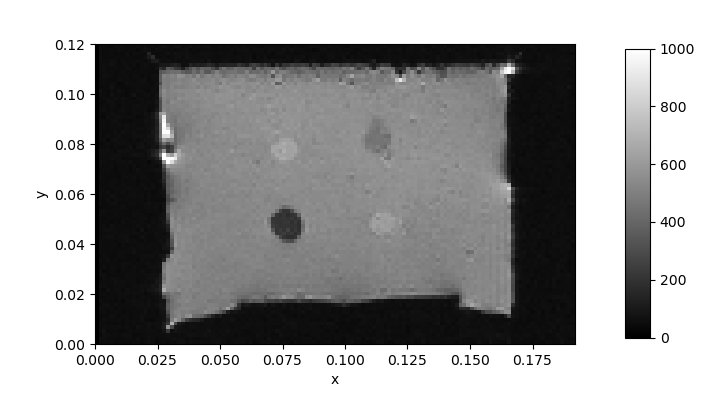

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [83]:
a = proc_data.a.mean(['frequency', 'component'])
mre_pinn.visual.XArrayViewer(a, ax_height=3, cmap='gray', vmin=0, vmax=1e3)

('sigma', 'threshold', 'x', 'y', 'z')
(6, 49, 128, 80, 25)


<IPython.core.display.Javascript object>


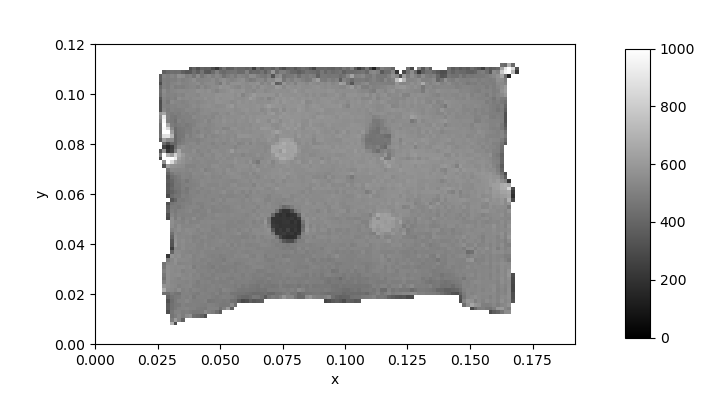

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [123]:
import scipy.ndimage
import skimage.draw

sigmas = np.arange(0.6, 1.1, 0.1)
thresholds = np.arange(160, 401, 5)

mask = a.expand_dims(dim={'sigma': sigmas, 'threshold': thresholds}, axis=[0, 1])
print(mask.dims)
mask_values = mask.values.copy()
print(mask_values.shape)

for i, sigma in enumerate(sigmas):
    a_sigma = scipy.ndimage.gaussian_filter(a, sigma=sigma)
    for j, threshold in enumerate(thresholds):
        
        m = (a_sigma > threshold)
        r, c = skimage.draw.rectangle(start=(25,15), end=(103,65))
        m[r,c,:] = 1
        
        mask_values[i,j] = m * a
        mask_values[i,j] = (1 - m) * 1000 + a
        
mask = mre_pinn.utils.as_xarray(mask_values, like=mask)
mre_pinn.visual.XArrayViewer(mask, ax_height=3, cmap='gray', vmin=0, vmax=1e3)

('x_loc', 'y_loc', 'x', 'y')
(56, 50, 128, 80)


<IPython.core.display.Javascript object>


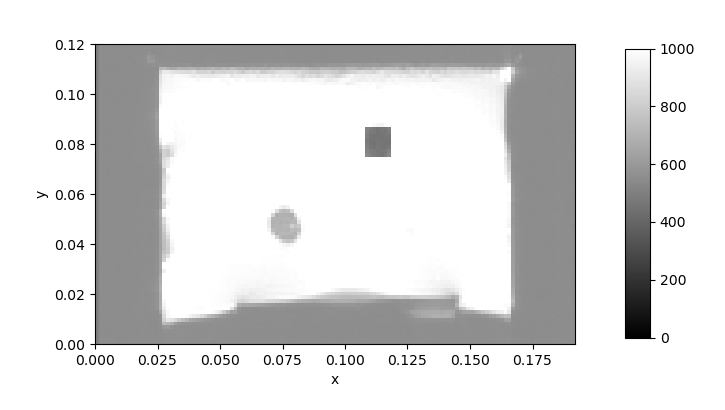

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [158]:
x_locs = np.arange(50, 78, 0.5)
y_locs = np.arange(30, 55, 0.5)

a_z = a.mean('z')
mask = 0 * a_z.expand_dims(dim={'x_loc': x_locs, 'y_loc': y_locs}, axis=[0, 1])
print(mask.dims)

mask_values = mask.values.copy()
print(mask_values.shape)

for i, x_loc in enumerate(x_locs):
    for j, y_loc in enumerate(y_locs):
        
        m = a_z * 0 + 0.5
        disk = skimage.draw.disk(center=(x_loc, y_loc), radius=4)
        m[disk] = 1
        
        mask_values[i,j] = m * a_z
        mask_values[i,j] = (1 - m) * 1000 + a_z
        
mask = mre_pinn.utils.as_xarray(mask_values, like=mask)
mre_pinn.visual.XArrayViewer(mask, ax_height=3, cmap='gray', vmin=0, vmax=1e3)

<IPython.core.display.Javascript object>


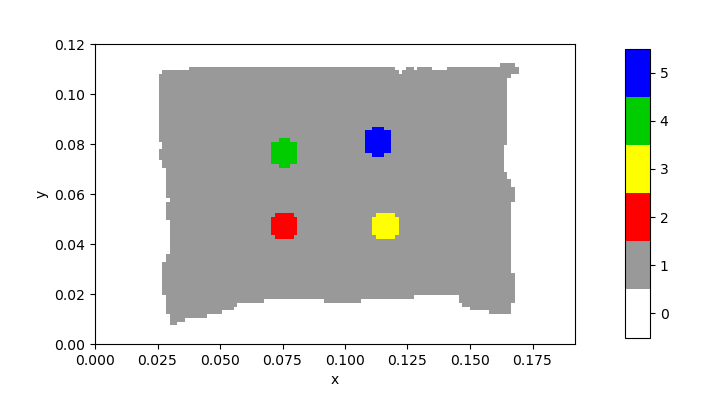

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [201]:
%autoreload

# detect phantom by Gaussian filtering and thresholding
matrix_mask = (scipy.ndimage.gaussian_filter(a, sigma=0.8) > 280).astype(int)

# ensure that there's no holes in matrix region
r, c = skimage.draw.rectangle(start=(25,15), end=(103,65))
matrix_mask[r, c, :] = 1

# identify cylindrical inclusions
disk_mask = np.zeros((128, 80), dtype=int)
disks = [
    skimage.draw.disk(center=(50.0, 31.0), radius=4),
    skimage.draw.disk(center=(77.0, 31.0), radius=4),
    skimage.draw.disk(center=(50.0, 50.5), radius=4),
    skimage.draw.disk(center=(75.0, 53.5), radius=4)
]
disk_mask[disks[0]] = 1
disk_mask[disks[1]] = 2
disk_mask[disks[2]] = 3
disk_mask[disks[3]] = 4

mask = matrix_mask + disk_mask[:,:,np.newaxis]

mask = mre_pinn.utils.as_xarray(mask, like=a)
mre_pinn.visual.XArrayViewer(mask, ax_height=3, vmin=-0.5, vmax=5.5, cmap=mre_pinn.visual.region_color_map(6))

In [179]:
# ground truth physical parameters
mu_springpot = np.array([0, 10830, 43301, 5228, 6001, 16281])[mask][np.newaxis,...]
alpha_springpot = np.array([0, 0.0226, 0.0460, 0.0272, 0.0247, 0.0345])[mask][np.newaxis,...]

axes = tuple(range(1, mu_springpot.ndim))
omega = 2 * np.pi * data.frequency
omega = np.expand_dims(omega, axis=axes)

print(mu_springpot.shape, omega.shape)

# complex shear modulus
eta = 1 # Pa s
mu = mu_springpot**(1 - alpha_springpot) * (1j * omega * eta)**alpha_springpot

mu.shape

(1, 128, 80, 25) (8, 1, 1, 1)


(8, 128, 80, 25)

<IPython.core.display.Javascript object>


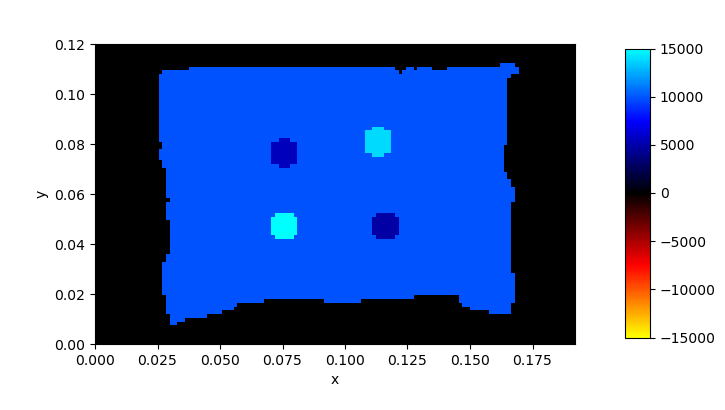

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [192]:
dx = 1.5e-3
mu_dims = ['frequency', 'x', 'y', 'z']
mu_coords = {
    'frequency': np.linspace(30, 100, mu.shape[0]),
    'x': np.arange(mu.shape[1]) * dx,
    'y': np.arange(mu.shape[2]) * dx,
    'z': np.arange(mu.shape[3]) * dx,
}
mu = xr.DataArray(mu, dims=mu_dims, coords=mu_coords) # Pa
mu.name = 'elastogram'

elast_kws = mre_pinn.visual.get_color_kws(mu)
elast_kws['vmax'] = 15e3
mre_pinn.visual.XArrayViewer(mu, ax_height=3, **elast_kws)

In [202]:
mask.shape, mu.shape

((128, 80, 25), (8, 128, 80, 25))

In [205]:
mask.dtype, mu.dtype

(dtype('int64'), dtype('complex128'))

In [206]:
np.save('../data/BIOQIC/phantom_regions.npy', mask)
np.save('../data/BIOQIC/phantom_elastogram.npy', mu)

In [271]:
%autoreload

data, test_data = mre_pinn.data.load_bioqic_dataset('../data/BIOQIC', 'phantom', downsample=False)
data

Loading ../data/BIOQIC/phantom_unwrapped_dejittered.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    info: <class 'numpy.ndarray'> (1, 1) [('dx_m', 'O'), ('dy_m', 'O'), ('dz_m', 'O'), ('frequencies_Hz', 'O'), ('index_description', 'O'), ('size', 'O')]
    magnitude: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) uint16
    phase_unwrap_noipd: <class 'numpy.ndarray'> (80, 128, 25, 8, 3, 8) float64
Loading ../data/BIOQIC/phantom_elastogram.npy
     <class 'numpy.ndarray'> (8, 128, 80, 25) complex128
Loading ../data/BIOQIC/phantom_regions.npy
     <class 'numpy.ndarray'> (128, 80, 25) int64
Multi frequency 3D
<xarray.Dataset>
Dimensions:         (frequency: 8, component: 3, z: 25, x: 128, y: 80)
Coordinates:
  * frequency       (frequency) float64 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0
  * component       (component) <U1 'z' 'y' 'x'
  * z               (z) float64 0.0 0.0015 0.003 0.0045 ... 0.033 0.0345 0.036
  * x               (x)

<xarray.Dataset>
Dimensions:         (frequency: 8, component: 3, z: 25, x: 128, y: 80)
Coordinates:
  * frequency       (frequency) float64 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0
  * component       (component) <U1 'z' 'y' 'x'
  * z               (z) float64 0.0 0.0015 0.003 0.0045 ... 0.033 0.0345 0.036
  * x               (x) float64 0.0 0.0015 0.003 0.0045 ... 0.1875 0.189 0.1905
  * y               (y) float64 0.0 0.0015 0.003 0.0045 ... 0.1155 0.117 0.1185
Data variables:
    a               (frequency, x, y, z, component) float64 0.0 0.0 ... 46.88
    u               (frequency, x, y, z, component) complex128 (-525.22761241...
    mu              (frequency, x, y, z) complex128 0j 0j 0j 0j ... 0j 0j 0j 0j
    spatial_region  (x, y, z) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    Ku              (frequency, x, y, z, component) complex128 (-245.24621905...
    Lu              (frequency, x, y, z, component) complex128 (240895913.844...
    Mu              (frequency, x, y, z) complex128 (44.190510896703195+48.19...

<IPython.core.display.Javascript object>


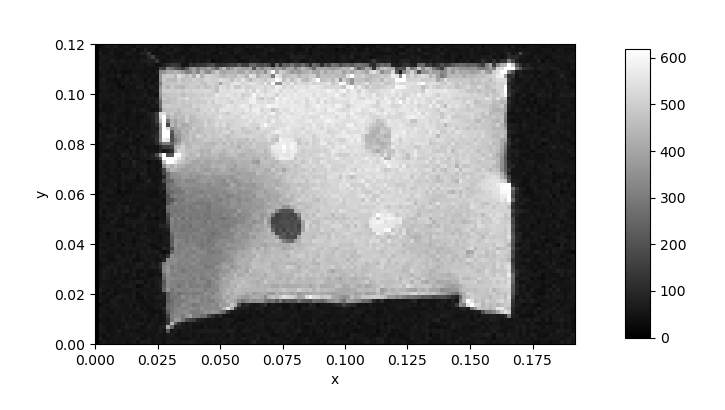

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


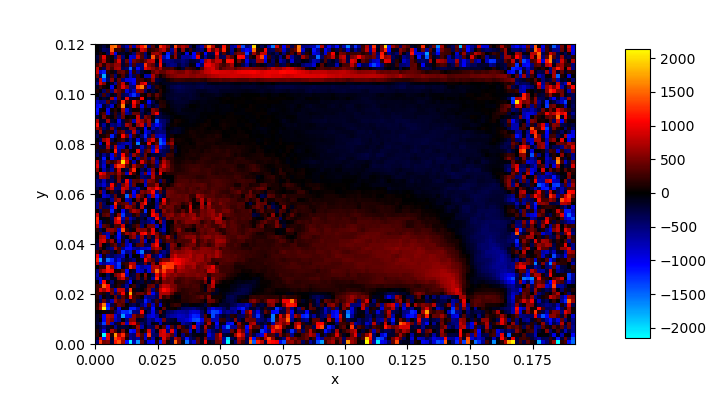

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


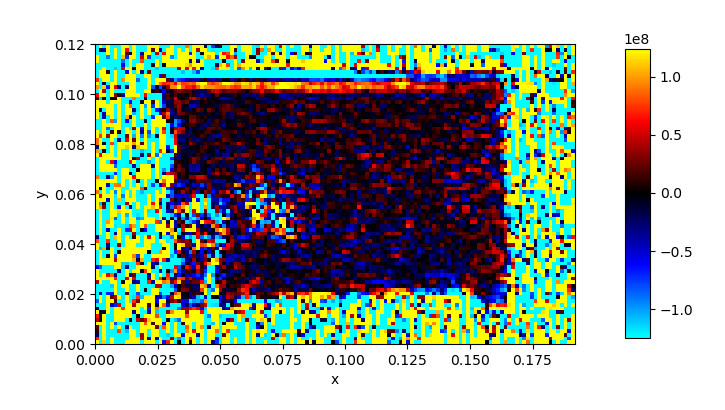

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


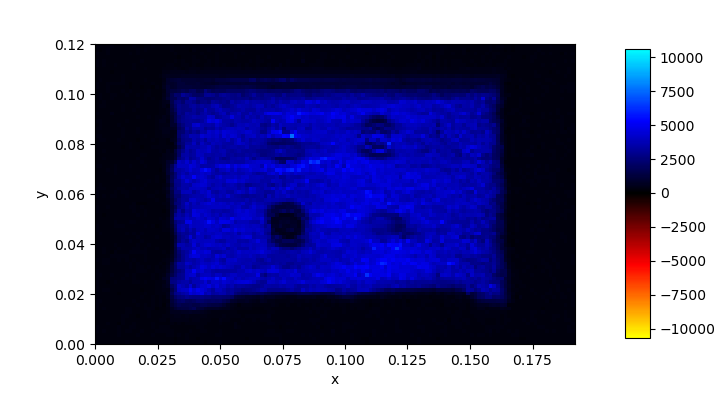

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

  height_ratios=ax_height,



<IPython.core.display.Javascript object>


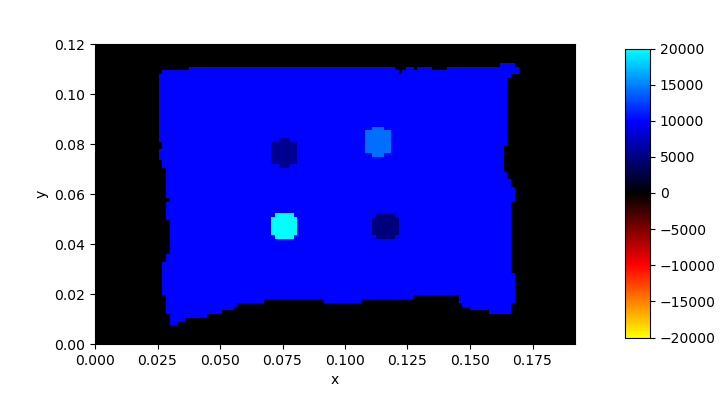

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [272]:
anat_kws = mre_pinn.visual.get_color_kws(data.a)
wave_kws = mre_pinn.visual.get_color_kws(data.u)
laplace_kws = mre_pinn.visual.get_color_kws(data.Lu, pct=50)
elast_kws = mre_pinn.visual.get_color_kws(data.Mu, pct=50)
mask_kws = mre_pinn.visual.get_color_kws(data.spatial_region)
elast_kws['vmax'] = 20e3

mre_pinn.visual.XArrayViewer(data.a, ax_height=3, **anat_kws)
mre_pinn.visual.XArrayViewer(data.u, ax_height=3, **wave_kws)
mre_pinn.visual.XArrayViewer(data.Lu, ax_height=3, **laplace_kws)
mre_pinn.visual.XArrayViewer(data.Mu.mean('frequency'), ax_height=3, polar=True, **elast_kws)
mre_pinn.visual.XArrayViewer(data.mu.mean('frequency'), ax_height=3, polar=True, **elast_kws)